In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import json

from lobio.simulator import Simulator
from lobio.accounting.pnl_counter import PnL_Counter
from lobio.model.avellaneda_stoikov_model import AvellanedaStoikov
from lobio.lob.limit_order import Order, PRICE_TICK, AMOUNT_TICK
from lobio.lob.order_book import TraderId, OrderBook
from lobio.utils.utils import group_diffs, group_orders

%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
diffs_file = "../data/diffs_prepared.npy"
init_lob_file = "../data/init_lob_prepared.npy"
orders_file = "../data/orders_prepared.npy"

with open(init_lob_file, 'rb') as file:
    init_lob = np.load(file)
with open(diffs_file, 'rb') as file:
    diffs = np.load(file)
with open(orders_file, 'rb') as file:
    orders = np.load(file)

In [3]:
diffs_grouped = group_diffs(diffs)
orders_per_diff = group_orders(orders, len(diffs_grouped))

100%|██████████| 23163/23163 [00:00<00:00, 68544.51it/s]


In [6]:
diffs_grouped[142][0]

1710532919184

In [6]:
t0 = diffs_grouped[0][0]
T = diffs_grouped[-1][0] + 100
q0 = 0

pnl_counter = PnL_Counter(q0=q0)
alpha = AvellanedaStoikov(T=T, t_start=t0, q0=q0, k=2, sigma=3, gamma=0.5, order_quote=1)
simulator = Simulator(diffs_grouped, orders_per_diff, init_lob, alpha, pnl_counter, T)

In [5]:
%lprun -f simulator.run_maker -f OrderBook.apply_historical_update -f OrderBook.update_bids -f OrderBook.update_asks -f OrderBook.set_ask_limit_order -f OrderBook.set_bid_limit_order -f OrderBook.set_sell_market_order -f OrderBook.set_buy_market_order -f OrderBook.remove_bid_ask_intersection simulator.run_maker(market_latency=10, local_latency=10)

100%|██████████| 23209/23209 [01:25<00:00, 272.41it/s]


Timer unit: 1e-09 s

Total time: 0.0348477 s
File: /home/bogdan/diplom/lobio/lob/order_book.py
Function: set_bid_limit_order at line 106

Line #      Hits         Time  Per Hit   % Time  Line Contents
   106                                               def set_bid_limit_order(self, limit_order: Order):
   107      1548   19228705.0  12421.6     55.2          index = bisect_left(self.bids, -limit_order.base, key=lambda x: -x.base)
   108      1548    1544600.0    997.8      4.4          if index == len(self.bids):
   109                                                       self.bids.append(PriceLevel(limit_order))
   110      1548    1718101.0   1109.9      4.9          elif self.bids[index].base == limit_order.base:
   111       175     796001.0   4548.6      2.3              self.bids[index].add_limit_order(limit_order)
   112                                                   else:
   113      1373   11560302.0   8419.7     33.2              self.bids.insert(index, PriceLevel(limit_

In [7]:
run_data = simulator.run_maker(market_latency=10, local_latency=10)

  1%|          | 142/23163 [00:00<00:01, 13748.32it/s]


IndexError: list index out of range

In [9]:
orders_per_diff[142]

[(1710532919154,
  Order(base=367596, quote=115844, side=1, type=1, trader_id=<TraderId.MARKET: 0>)),
 (1710532919154,
  Order(base=367506, quote=32237, side=1, type=0, trader_id=<TraderId.MARKET: 0>)),
 (1710532919155,
  Order(base=367506, quote=43, side=-1, type=1, trader_id=<TraderId.MARKET: 0>)),
 (1710532919155,
  Order(base=367505, quote=1497, side=1, type=1, trader_id=<TraderId.MARKET: 0>)),
 (1710532919155,
  Order(base=367506, quote=32194, side=-1, type=1, trader_id=<TraderId.MARKET: 0>))]

In [12]:
diffs_grouped[142][0]

1710532919184

In [8]:
simulator.order_book

                                    PriceLevel(367597, 57761, 1)
                                    PriceLevel(367598, 26661, 1)
                                    PriceLevel(367600, 2464, 1)
                                    PriceLevel(367604, 325, 1)
                                    PriceLevel(367608, 2000, 1)
                                    PriceLevel(367614, 542, 1)
                                    PriceLevel(367615, 4500, 1)
                                    PriceLevel(367619, 2099, 1)
                                    PriceLevel(367620, 2464, 1)
                                    PriceLevel(367621, 2000, 1)
                                    PriceLevel(367630, 542, 1)
                                    PriceLevel(367631, 6, 1)
                                    PriceLevel(367632, 45830, 1)
                                    PriceLevel(367633, 1334, 1)
                                    PriceLevel(367636, 271, 1)
                                    PriceLev

In [18]:
pnl_history = pnl_counter.calculate_pnl()

agent asset amount - -2886, agent money amount - 1056904398


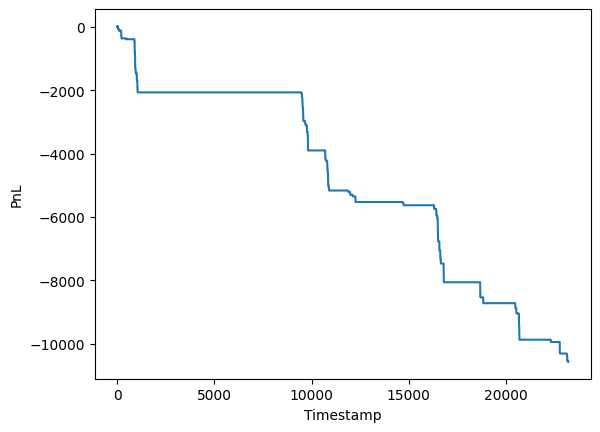

In [23]:
print(f"agent asset amount - {run_data[0]}, agent money amount - {run_data[1]}")
plt.plot(pnl_history / (10**(AMOUNT_TICK + PRICE_TICK)))
plt.xlabel("Timestamp")
plt.ylabel("PnL")
plt.show()

In [24]:
(run_data[0] * simulator.order_book.mid_price()  + run_data[1]) / 10**(AMOUNT_TICK + PRICE_TICK)

-15.34659

In [25]:
run_data[0] / 10**AMOUNT_TICK, simulator.order_book.mid_price() / 10**PRICE_TICK, run_data[1] / 10**AMOUNT_TICK / 10**PRICE_TICK

(-2.886, 3667.495, 10569.04398)